# 📈 Competitive Trends EDA

### 🎯 Research Question:
**What statistical and gameplay-related factors—such as typing, base stats, and abilities—are most strongly associated with high usage rates in competitive Pokémon formats, and what common trends can be identified among top-used Pokémon?**

This notebook investigates patterns in competitive usage data across Smogon and VGC formats by analyzing Pokémon attributes including:
- Base stats (HP, Attack, Speed, etc.)
- Typing (primary & secondary)
- Abilities (primary/special/event)

The goal is to identify **statistical correlations**, **cluster patterns**, and potential **predictors of meta relevance**.

In [1]:
# 📦 Import libraries
import os
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from collections import Counter

# 📄 Load environment variables
load_dotenv()

DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

# 🧠 Connect to the database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# ✅ Test connection
print("Database connection established!")


Database connection established!


In [2]:
df = pd.read_sql("SELECT * FROM pokemon_competitive_factors_view", conn)
df.head()


/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_80535/694259048.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM pokemon_competitive_factors_view", conn)


,pokemon_id,pokemon_name,alternate_form_name,health_stat,attack_stat,defense_stat,special_attack_stat,special_defense_stat,speed_stat,base_stat_total,...,smogon_vgc_usage_2024,worlds_vgc_usage_2022,worlds_vgc_usage_2023,worlds_vgc_usage_2024,primary_type,secondary_type,primary_ability,secondary_ability,hidden_ability,event_ability
0,1,Bulbasaur,None,45,49,49,65,65,45,318,...,0.0000,NaN,NaN,NaN,Grass,Poison,Overgrow,None,Chlorophyll,None
1,2,Ivysaur,None,60,62,63,80,80,60,405,...,0.0000,NaN,NaN,NaN,Grass,Poison,Overgrow,None,Chlorophyll,None
2,3,Venusaur,None,80,82,83,100,100,80,525,...,0.4441,19.62,NaN,0.09,Grass,Poison,Overgrow,None,Chlorophyll,None
3,4,Venusaur,Mega,80,100,123,122,120,80,625,...,NaN,NaN,NaN,NaN,Grass,Poison,Thick Fat,None,None,None
4,5,Charmander,None,39,52,43,60,50,65,309,...,NaN,NaN,NaN,NaN,Fire,None,Blaze,None,Solar Power,None


## ✅ Goal

We want to analyze the **top 30 Pokémon** (per format) from the `competitive_pokemon_view` for **Smogon 2023** and **Worlds 2023**, and investigate:

- 📊 Stat trends (individual and total)  
- 🔮 Common types  
- 🧠 Common abilities 

In [3]:
smogon_2023 = pd.read_sql("""
    SELECT *
    FROM pokemon_competitive_factors_view
    WHERE smogon_vgc_usage_2023 IS NOT NULL
    ORDER BY smogon_vgc_usage_2023 DESC
    LIMIT 30;
""", conn)

worlds_2023 = pd.read_sql("""
    SELECT *
    FROM pokemon_competitive_factors_view
    WHERE worlds_vgc_usage_2023 IS NOT NULL
    ORDER BY worlds_vgc_usage_2023 DESC
    LIMIT 30;
""", conn)


/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_80535/843391896.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  smogon_2023 = pd.read_sql("""
/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_80535/843391896.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  worlds_2023 = pd.read_sql("""


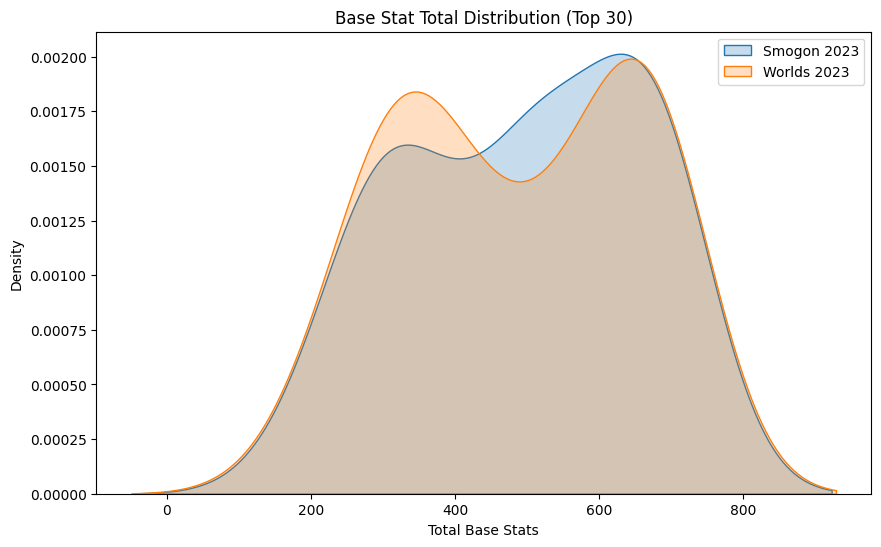

In [4]:
plt.figure(figsize=(10, 6))
sns.kdeplot(smogon_2023["base_stat_total"], label="Smogon 2023", fill=True)
sns.kdeplot(worlds_2023["base_stat_total"], label="Worlds 2023", fill=True)
plt.title("Base Stat Total Distribution (Top 30)")
plt.xlabel("Total Base Stats")
plt.legend()
plt.show()

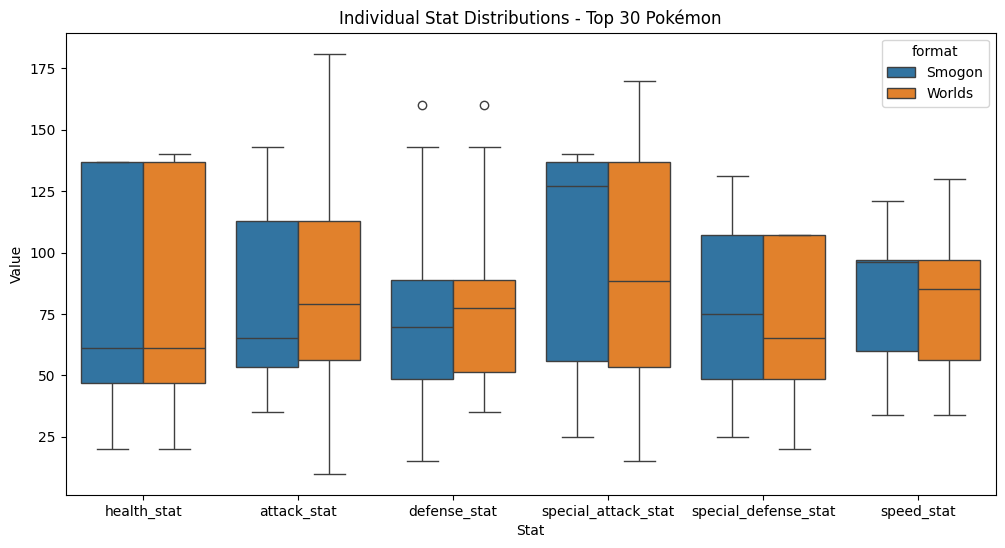

In [6]:
stat_cols = ["health_stat", "attack_stat", "defense_stat", 
             "special_attack_stat", "special_defense_stat", "speed_stat"]

melted_stats = pd.concat([
    smogon_2023.assign(format="Smogon")[stat_cols + ["format"]],
    worlds_2023.assign(format="Worlds")[stat_cols + ["format"]]
]).melt(id_vars="format", var_name="Stat", value_name="Value")

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_stats, x="Stat", y="Value", hue="format")
plt.title("Individual Stat Distributions - Top 30 Pokémon")
plt.show()


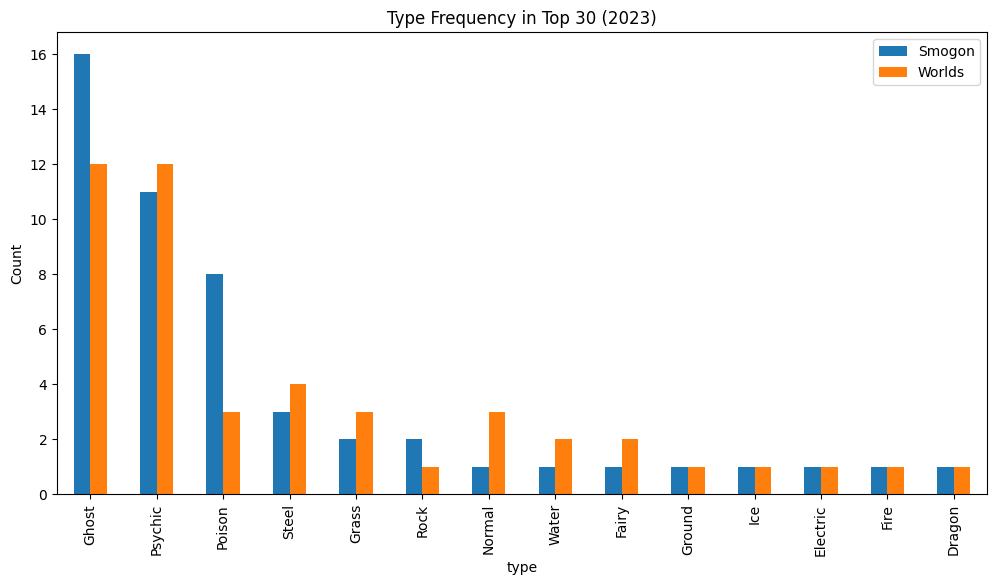

In [7]:
def get_type_counts(df):
    return Counter(df["primary_type"].tolist() + df["secondary_type"].dropna().tolist())

smogon_types = get_type_counts(smogon_2023)
worlds_types = get_type_counts(worlds_2023)

type_df = pd.DataFrame([
    {"type": t, "Smogon": smogon_types.get(t, 0), "Worlds": worlds_types.get(t, 0)}
    for t in set(smogon_types.keys()).union(worlds_types.keys())
])

type_df = type_df.sort_values(["Smogon", "Worlds"], ascending=False)

type_df.set_index("type")[["Smogon", "Worlds"]].plot(kind="bar", figsize=(12, 6))
plt.title("Type Frequency in Top 30 (2023)")
plt.ylabel("Count")
plt.show()

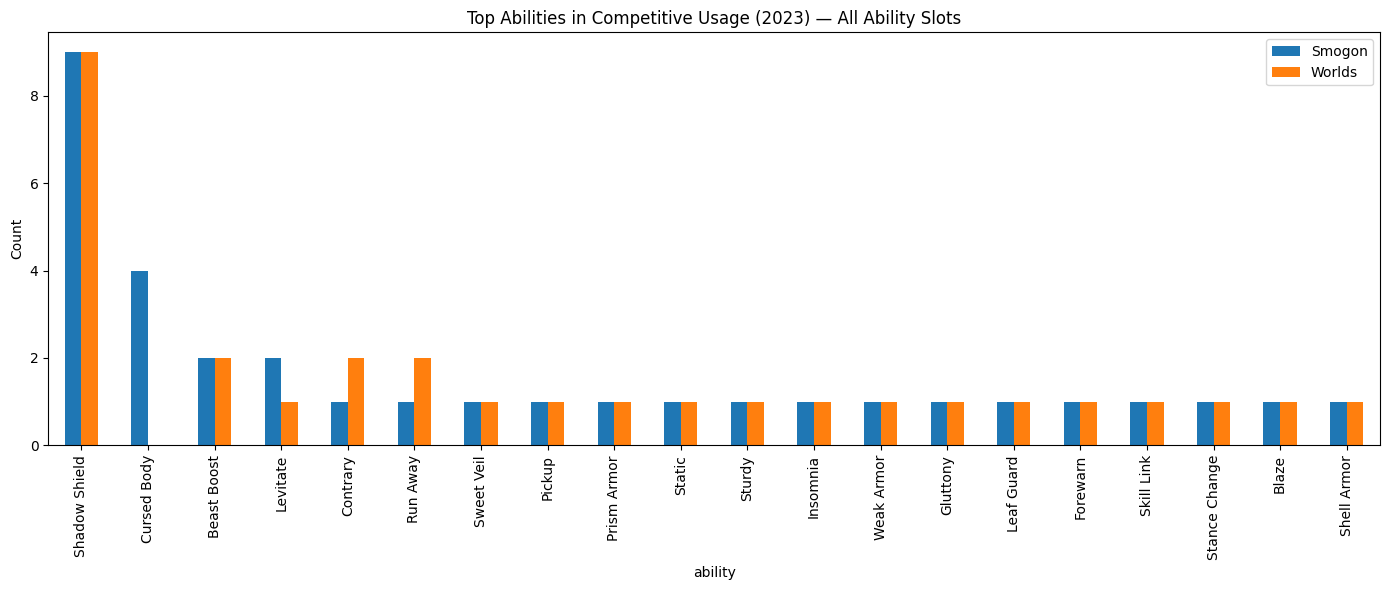

In [11]:
def ability_counts(df):
    all_abilities = (
        df["primary_ability"].dropna().tolist()
        + df["secondary_ability"].dropna().tolist()
        + df["hidden_ability"].dropna().tolist()
        + df["event_ability"].dropna().tolist()
    )
    return Counter(all_abilities)

# Count abilities for both formats
smogon_abilities = ability_counts(smogon_2023)
worlds_abilities = ability_counts(worlds_2023)

# Combine into one DataFrame
ability_df = pd.DataFrame([
    {"ability": a, "Smogon": smogon_abilities.get(a, 0), "Worlds": worlds_abilities.get(a, 0)}
    for a in set(smogon_abilities.keys()).union(worlds_abilities.keys())
])

# Show top 15 total-used abilities
top_abilities = ability_df.set_index("ability")[["Smogon", "Worlds"]].sort_values(
    by=["Smogon", "Worlds"], ascending=False
).head(20)

# Plot
top_abilities.plot(kind="bar", figsize=(14, 6))
plt.title("Top Abilities in Competitive Usage (2023) — All Ability Slots")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


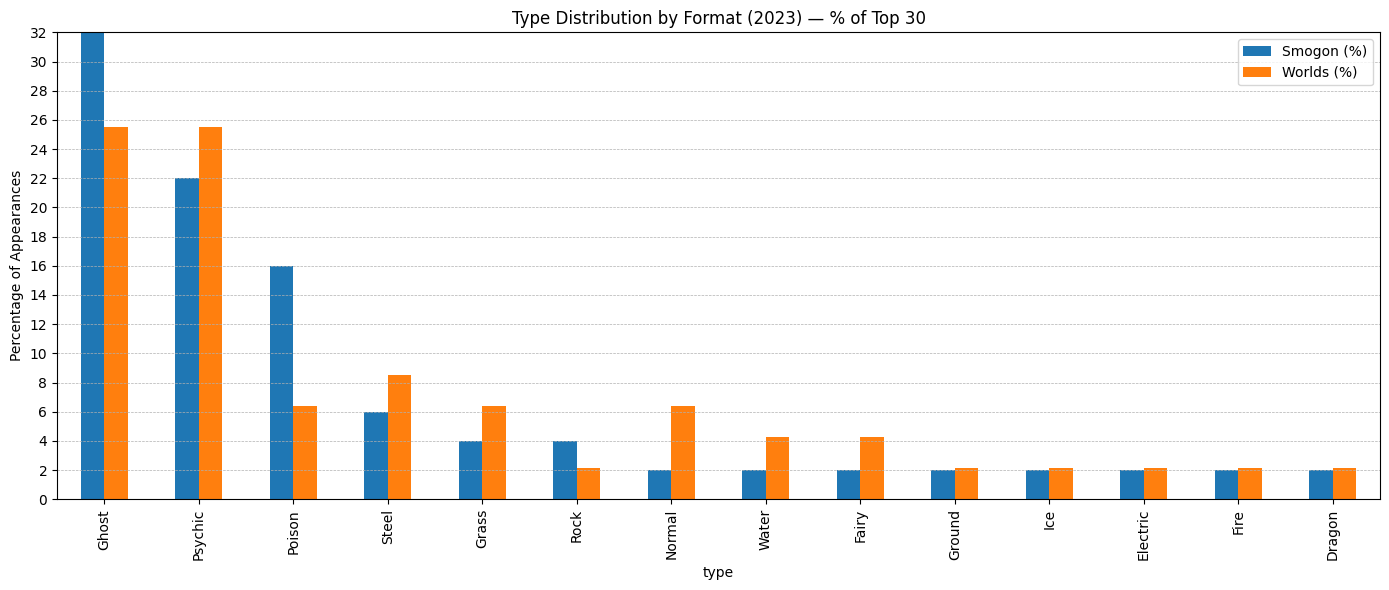

In [14]:
def type_frequency(df):
    types = df["primary_type"].tolist() + df["secondary_type"].dropna().tolist()
    return Counter(types)

# Raw counts
smogon_type_counts = type_frequency(smogon_2023)
worlds_type_counts = type_frequency(worlds_2023)

# Normalize to percentage
def normalize(counter):
    total = sum(counter.values())
    return {k: v / total * 100 for k, v in counter.items()}

smogon_type_pct = normalize(smogon_type_counts)
worlds_type_pct = normalize(worlds_type_counts)

# Combine into a DataFrame
type_df = pd.DataFrame([
    {"type": t, "Smogon (%)": smogon_type_pct.get(t, 0), "Worlds (%)": worlds_type_pct.get(t, 0)}
    for t in set(smogon_type_pct.keys()).union(worlds_type_pct.keys())
])

# Plotting
max_val = type_df[["Smogon (%)", "Worlds (%)"]].values.max()
ymax = np.ceil(max_val / 2) * 2 

type_df.set_index("type")[["Smogon (%)", "Worlds (%)"]].sort_values(
    by=["Smogon (%)", "Worlds (%)"], ascending=False
).plot(kind="bar", figsize=(14, 6))

plt.title("Type Distribution by Format (2023) — % of Top 30")
plt.ylabel("Percentage of Appearances")
plt.yticks(np.arange(0, ymax + 1, 2))  # ticks every 2%
plt.ylim(0, ymax)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


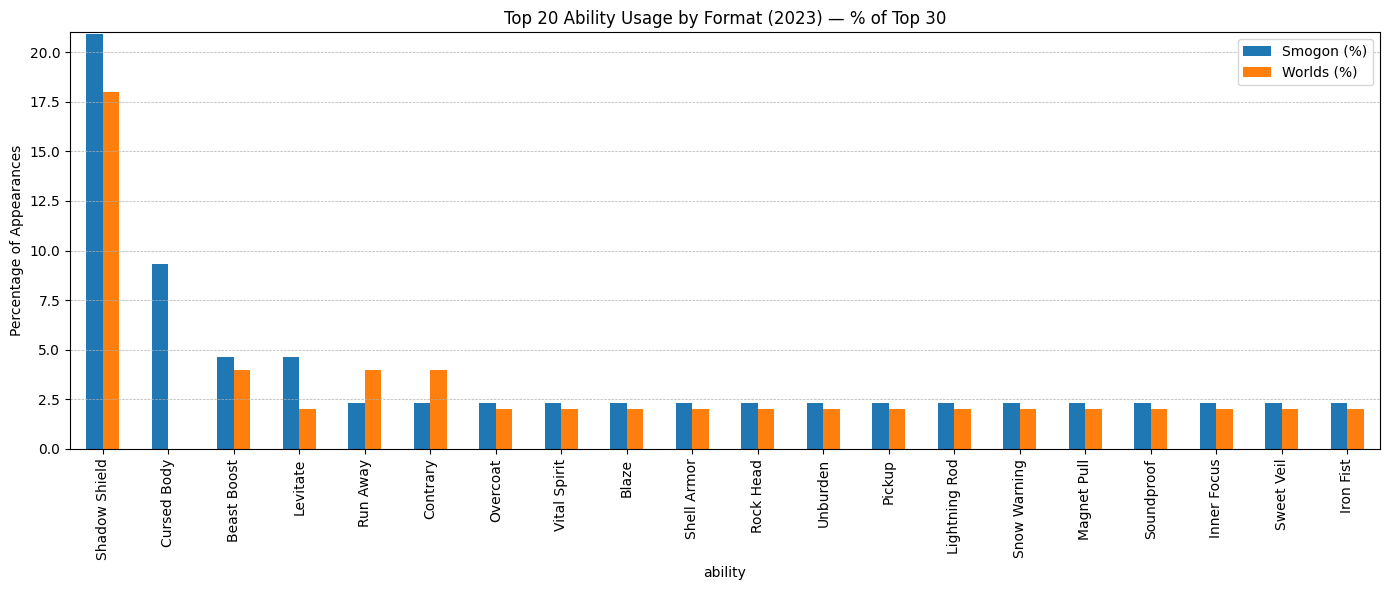

In [28]:
def ability_frequency(df):
    abilities = df["primary_ability"].tolist() + \
                df["secondary_ability"].dropna().tolist() + \
                df["hidden_ability"].dropna().tolist() + \
                df["event_ability"].dropna().tolist()
    return Counter(abilities)

# Raw counts
smogon_abilities = ability_frequency(smogon_2023)
worlds_abilities = ability_frequency(worlds_2023)

# Normalize
smogon_abilities_pct = normalize(smogon_abilities)
worlds_abilities_pct = normalize(worlds_abilities)

# Combine into a DataFrame
ability_df = pd.DataFrame([
    {"ability": a, "Smogon (%)": smogon_abilities_pct.get(a, 0), "Worlds (%)": worlds_abilities_pct.get(a, 0)}
    for a in set(smogon_abilities_pct.keys()).union(worlds_abilities_pct.keys())
])


# Get top 20 abilities by combined percentage
top_abilities_pct = ability_df.copy()
top_abilities_pct["Total"] = top_abilities_pct["Smogon (%)"] + top_abilities_pct["Worlds (%)"]
top_abilities_pct = top_abilities_pct.sort_values("Total", ascending=False).head(20)

# Determine precise y-axis range
max_val = top_abilities_pct[["Smogon (%)", "Worlds (%)"]].values.max()
ymax = np.ceil(max_val * 10) / 10   # round up to nearest 0.1


# Plot
top_abilities_pct.set_index("ability")[["Smogon (%)", "Worlds (%)"]].plot(
    kind="bar", figsize=(14, 6)
)

plt.title("Top 20 Ability Usage by Format (2023) — % of Top 30")
plt.ylabel("Percentage of Appearances")
plt.ylim(0, ymax)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

